[XEE](https://github.com/google/Xee) is an python package for working with Google Earth Engine data with [XArray](https://docs.xarray.dev/en/stable/). XEE makes it possible to leverage the strengths of both GEE and the Python ecosystem around XArray.

We will learn how to use XEE to extract and process a NDVI time-series for a location.


#### Installation

Let's install the required packages in the Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee

In [ ]:
import ee
import xarray
import matplotlib.pyplot as plt

#### Initialization

First of all, you need to run the following cells to initialize the API and authorize your account. You must have a Google Cloud Project associated with your GEE account. Replace the `cloud_project` with your own project from [Google Cloud Console](https://console.cloud.google.com/).

We are using the [High-volume Endpoint](https://developers.google.com/earth-engine/cloud/highvolume) which supports large number of concurrent requests and is recommended when working with XEE.

In [ ]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com'
    )
except:
    ee.Authenticate()
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com'
    )

#### Select a location.

In [ ]:
geometry = ee.Geometry.Point([82.60759592318209, 27.163481733946846])

#### Preprocess the data in GEE

We start with the Sentinel-2 L1C collection. We pre-process the data by applying cloud masking and pixel scaling.

In [ ]:
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

filtered = s2 \
  .filter(ee.Filter.date('2017-01-01', '2018-01-01')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.bounds(geometry))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
  qaBand = 'cs'
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
  .map(maskLowQA)

# Write a function that computes NDVI for an image and adds it as a band
# Create a new image to overcome https://github.com/google/Xee/issues/88
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.multiply(0.0001).addBands(ndvi)\
    .copyProperties(image, ['system:time_start'])

# Map the function over the collection
withNdvi = filteredMasked.map(addNDVI)


#### Load ImageCollection as XArray Dataset

Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the region of interest and extract the ImageCollection using the `ee` engine.

In [ ]:
ds = xarray.open_dataset(
    withNdvi,
    engine='ee',
    crs='EPSG:3857',
    scale=10,
    geometry=geometry,
    ee_mask_value=-9999,
)

ds

Select the `ndvi` band.

In [ ]:
ndvi_time_series = ds.ndvi

Run `compute()` to fetch the pixels from Earth Engine. This may take some time depending on the size of the request. This is a time-series at a single pixel, so we also `squeeze()` to remove the X and Y dimensions and get an array of NDVI values.

In [ ]:
original_time_series = ndvi_time_series.compute()
original_time_series = original_time_series.squeeze()
original_time_series

Plot the time-series.

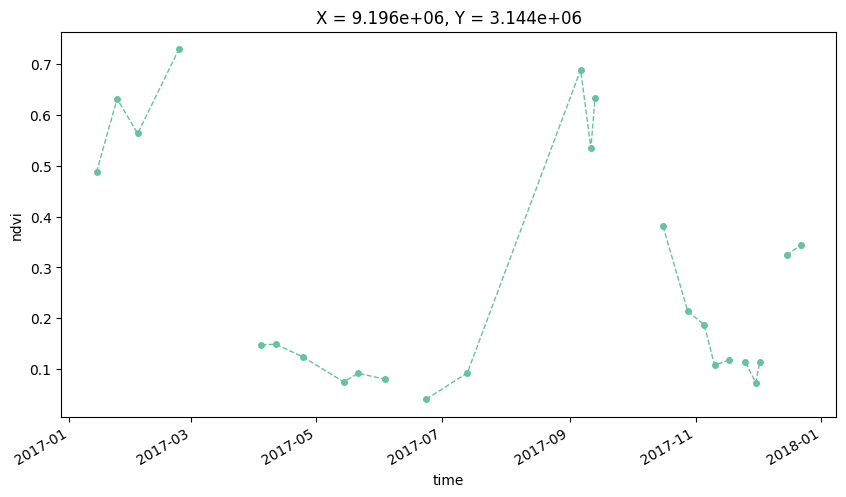

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
original_time_series.plot.line(
    ax=ax, x='time',
    marker='o', color='#66c2a4', linestyle='--', linewidth=1, markersize=4)
plt.show()

#### Process Time-Series using XArray

We use XArray's excellent time-series processing functionality to process the time-series. First, we create a regularly spaced time-series.

In [ ]:
time_series_resampled = original_time_series\
  .resample(time='5d').mean(dim='time')
time_series_resampled

Next we fill the cloud-masked pixels with linearly interpolated values from temporal neighbors.

In [ ]:
time_series_interpolated = time_series_resampled\
  .interpolate_na('time', use_coordinate=False)
time_series_interpolated

We also apply a moving-window smoothing to remove noise.

In [ ]:
time_series_smooth = time_series_interpolated\
  .rolling(time=3, center=True).mean()
time_series_smooth

A moving-window smoothing removed the first and last values of the time-series. We anchor the smoothed time-series with the values from the original time-series.

In [ ]:
time_series_smooth[0] = original_time_series[0]
time_series_smooth[-1] = original_time_series[-1]
time_series_smooth

Plot the original and smoothed time-series.

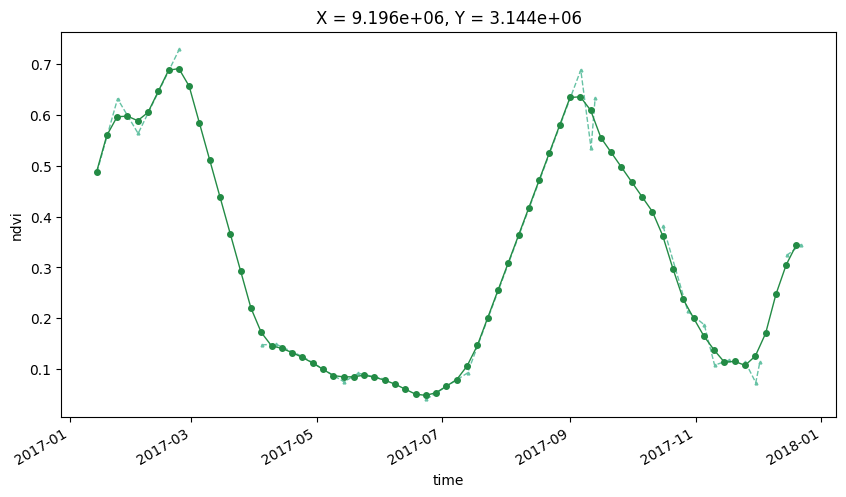

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
original_time_series.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
time_series_smooth.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
plt.show()

#### Download the Time-Series

Convert the DataArray to a Pandas DataFrame and save it as a CSV file.

In [ ]:
df = time_series_smooth.to_dataframe('ndvi').reset_index()
df

In [ ]:
output_filename = 'smoothed_time_series.csv'
df[['time', 'ndvi']].to_csv(output_filename, index=False)

### Exercise

Replace the `geometry` with the location of your choice. Extract and download the smoothed time-series as a CSV file.